## Multiparameter optimized split

- **Approach:**  This approach utilizes multi-objective genetic algorithms to split data into training and test sets. The test set consists of data that exhibits a better profile of the predefined objectives commonly used in drug discovery project.
- **Characteristics**: The goal of using multi-objective optimization algorithms to split datasets is to mimic the differences in molecular properties observed in real-world medicinal chemistry project datasets. This method provides a reliable estimate of the model's ability to generalize to new data. It can also be valuable for answering relevant questions in drug discovery, such as "Is it possible to make predictions on compounds with a better profile than the compounds on which the model was trained?"
- **Application:** Most of the drug development projects requires a number of iterations of molecular design and experimental validation over a series of time points. The subsequent design cycles typically involve molecules that have one or multiple improved features in their molecular profile. These improvements may include a wider range of molecular weight, new chemical structures and scaffolds that are important for structure-activity relationship (SAR), enhanced bioactivity, improved drug metabolism and pharmacokinetic properties, and more. In these cases, this approach provides a robust estimate of the model's ability to **generalize to new data**. A model chosen through this splitting approach proves highly valuable in the **lead optimization** phase. However, if the molecular profiles have no significant changes in the dataset, applying the this split would have no difference to a random split.
- **Code availability:**  `splito.simpd.SIMPDSplitter`

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
from splito.simpd import SIMPDSplitter
from utils import visualize_chemspace

In [2]:
# load dataset
data = dm.data.solubility()
data.head(5)

,mol,ID,NAME,SOL,SOL_classification,smiles,split
0,<rdkit.Chem.rdchem.Mol object at 0x1385d5c40>,1,n-pentane,-3.18,(A) low,CCCCC,train
1,<rdkit.Chem.rdchem.Mol object at 0x1385d5d20>,2,cyclopentane,-2.64,(B) medium,C1CCCC1,train
2,<rdkit.Chem.rdchem.Mol object at 0x1385d5e00>,3,n-hexane,-3.84,(A) low,CCCCCC,train
3,<rdkit.Chem.rdchem.Mol object at 0x1385d5ee0>,4,2-methylpentane,-3.74,(A) low,CCCC(C)C,train
4,<rdkit.Chem.rdchem.Mol object at 0x1385d5fc0>,6,"2,2-dimethylbutane",-3.55,(A) low,CCC(C)(C)C,train


SOL_classification
(A) low       Axes(0.125,0.11;0.775x0.77)
(B) medium    Axes(0.125,0.11;0.775x0.77)
(C) high      Axes(0.125,0.11;0.775x0.77)
Name: SOL, dtype: object

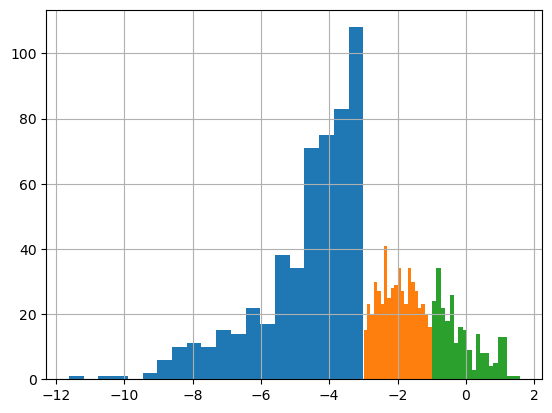

In [3]:
data.groupby("SOL_classification")["SOL"].hist(bins=20)

In [4]:
data_col = "CLASS_SOL"
mol_col = "mol"

The current version of `SIMPDSplitter` implementation only support binary data value. 
Therefore, we convert the `SOL_classification` to binary format by setting `(C) high` as `positive` and the rest are `negative`.

In [5]:
data.loc[data["SOL_classification"] == "(C) high", data_col] = 1
data.loc[data["SOL_classification"] != "(C) high", data_col] = 0

### Define parameters for `SIMPDSplitter`

In [6]:
# the running time is considerable long. The parameters should also be improved.
args = {}
args["n_splits"] = 5

**Genetic algorithm parameters**

In [7]:
args["pop_size"] = 500
args["ngens"] = 10

**SIMPD objectives and constraints**

Eight objectives were selected for the MOGA, based the analysis of descriptor differences and the spatial statistics between training and test sets in the NIBR medicinal chemistry projects: \
1.$∆_{test-train}median(SA\_Score)=0.28$ \
2.$∆_{test-train}median(HeavyAtomCount)=3.1$ \
3.$∆_{test-train}median(TPSA)=13.2$ \
4.$∆_{test-train}median(fr\_benzene/1000\ HeavyAtoms)=-8.8$ \
5.$frac_{active}(train)=value\ from\ dataset$ \
6.$frac_{active}(test)=value\ from\ dataset$ \
7.$10<\sum_{G}−\sum_{F′}<30 $ \
8.$\sum_{G}>70$ 

See more details in:
- https://chemrxiv.org/engage/chemrxiv/article-details/6406049e6642bf8c8f10e189
- `splito.simpd.SIMPDSpliter`

In [8]:
args["simpd_descriptors"] = None
args["target_train_frac_active"] = -1
args["target_test_frac_active"] = -1
args["target_delta_test_frac_active"] = None  # [0.11, 0.30] or None
args["target_GF_delta_window"] = (10, 30)
args["target_G_val"] = 70
args["max_population_cluster_entropy"] = 0.9
args["pareto_weight_GF_delta"] = 10
args["pareto_weight_G"] = 5

**Other parameters**

In [9]:
args["num_threads"] = 4
args["random_seed"] = 111
args["verbose"] = True
args["verbose_pymoo"] = True
args["progress"] = True
args["progress_leave"] = True

**Define the splitter and fit with the dataset**

In [10]:
simpd_splitter = SIMPDSplitter(**args)
result = simpd_splitter.fit(data[mol_col].values, data[data_col].values)

2023-09-21 15:24:10.433 | INFO     | splito.simpd.preprocess:preprocess_SIMPD_mols:55 - Compute descriptors and fingerprint values for the molecules.


Preprocess molecules:   0%|          | 0/1282 [00:00<?, ?it/s]

2023-09-21 15:24:13.880 | INFO     | splito.simpd.preprocess:preprocess_SIMPD_mols:78 - Compute the distance matrix for the molecules.
2023-09-21 15:24:15.119 | INFO     | splito.simpd.simpd:run_SIMPD:92 - Working with 1282 points and picking 256
2023-09-21 15:24:15.249 | INFO     | splito.simpd.simpd:run_SIMPD:108 - Clustering the starting points with a distance threshold of 0.65 and a cluster size threshold of 25.64.
2023-09-21 15:24:15.250 | INFO     | splito.simpd.simpd:run_SIMPD:111 - 2 clusters have been created of size: [380, 902]
2023-09-21 15:24:15.254 | INFO     | splito.simpd.simpd:run_SIMPD:145 - Start the optimization.


Optimization:   0%|          | 0/10 [00:00<?, ?it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        2 |      2 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      502 |     50 |  0.000000E+00 |  1.9557361575 |  0.2274187073 |         ideal
     3 |     1002 |    101 |  0.000000E+00 |  0.3846396339 |  0.5532088889 |         ideal
     4 |     1502 |    150 |  0.000000E+00 |  0.0371022279 |  0.0958904110 |         ideal
     5 |     2002 |    189 |  0.000000E+00 |  0.0175444602 |  0.0251593861 |         ideal
     6 |     2502 |    220 |  0.000000E+00 |  0.0038694125 |  0.0547127580 |         nadir
     7 |     3002 |    259 |  0.000000E+00 |  0.000000E+00 |  0.0076131687 |         nadir
     8 |     3502 |    269 |  0.000000E+00 |  0.000000E+00 |  0.0518923137 |         nadir
     9 |     4002 |    286 |  0.000000E+00 |  0.000000E+00 |  0.0130467301 |             f


2023-09-21 15:24:24.923 | INFO     | splito.simpd.simpd:run_SIMPD:173 - Found 324 solutions
2023-09-21 15:24:24.924 | INFO     | splito.simpd.simpd:run_SIMPD:176 - Scoring the solutions.
2023-09-21 15:24:24.924 | INFO     | splito.simpd.simpd:run_SIMPD:195 - Objective values for the best solution: [ 0.13588097  9.1        27.11       71.34057143  0.15186232  0.
  7.31640625]


    10 |     4502 |    324 |  0.000000E+00 |  0.000000E+00 |  0.0212191358 |         ideal


In all the generations, five of them are successful, one failed and three are inconclusive. 
The best solution will be used for splitting the data. 

In [11]:
train_idx, test_idx = next(simpd_splitter.split(data[mol_col].values))

### Check the distributions of train/test set generated by the `PerimeterSplit` and `MaxDissimilaritySplit` in the chemical space

In [12]:
data.loc[train_idx, "SIMPDSplit"] = "train"
data.loc[test_idx, "SIMPDSplit"] = "test"

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

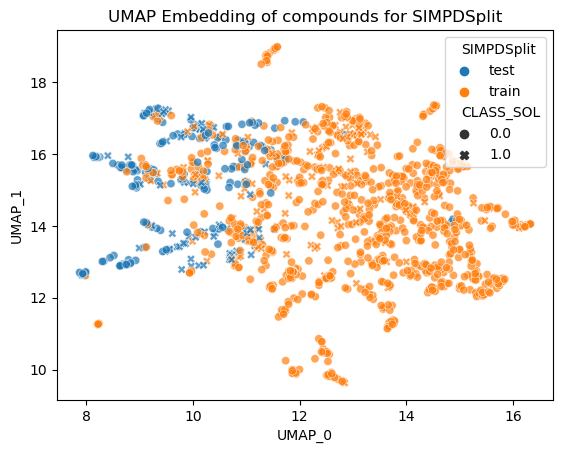

In [13]:
from utils import visualize_chemspace

visualize_chemspace(data, ["SIMPDSplit"], mol_col=mol_col, size_col="CLASS_SOL")